# Using more sophisticated images with Convolutional Neural Networks

Our task is to build a CNN to classify an incoming image as a cat or dog.  

We'll follow these steps:

1.   Explore the Example Data of Cats and Dogs
2.   Build and Train a Neural Network to recognize the difference between the two
3.   Evaluate the Training and Validation accuracy
4.   Solve overfitting problem.

## Explore the Example Data

Let's start by downloading our example data, a .zip of 2,000 JPG pictures of cats and dogs, and extracting it locally in `/tmp`.

**NOTE:** The 2,000 images used in this exercise are excerpted from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

In [ ]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O /tmp/cats_and_dogs_filtered.zip

--2021-08-01 01:22:50--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   254MB/s    in 0.3s    

2021-08-01 01:22:50 (254 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



The following python code will use the OS library to use Operating System libraries, giving you access to the file system, and the zipfile library allowing you to unzip the data. 

In [ ]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

The contents of the .zip are extracted to the base directory `/tmp/cats_and_dogs_filtered`, which contains `train` and `validation` subdirectories for the training and validation datasets, which in turn each contain `cats` and `dogs` subdirectories.

In short: The training set is the data that is used to tell the neural network model that 'this is what a cat looks like', 'this is what a dog looks like' etc. The validation data set is images of cats and dogs that the neural network will not see as part of the training, so you can test how well or how badly it does in evaluating if an image contains a cat or a dog.

One thing to pay attention to in this sample: We do not explicitly label the images as cats or dogs. We will use ImageGenerator to read images from subdirectories, and automatically label them from the name of that subdirectory. So, for example, you will have a 'training' directory containing a 'cats' directory and a 'dogs' one. ImageGenerator will label the images appropriately for you, reducing a coding step. 

Let's define each of these directories:

In [ ]:
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')


Now, let's see what the filenames look like in the `cats` and `dogs` `train` directories (file naming conventions are the same in the `validation` directory):

In [ ]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.289.jpg', 'cat.275.jpg', 'cat.168.jpg', 'cat.902.jpg', 'cat.660.jpg', 'cat.339.jpg', 'cat.628.jpg', 'cat.595.jpg', 'cat.140.jpg', 'cat.990.jpg']
['dog.12.jpg', 'dog.39.jpg', 'dog.42.jpg', 'dog.210.jpg', 'dog.228.jpg', 'dog.839.jpg', 'dog.369.jpg', 'dog.723.jpg', 'dog.305.jpg', 'dog.646.jpg']


Let's find out the total number of cat and dog images in the `train` and `validation` directories:

In [ ]:
print('total training cat images :', len(os.listdir(      train_cats_dir ) ))
print('total training dog images :', len(os.listdir(      train_dogs_dir ) ))

print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


For both cats and dogs, we have 1,000 training images and 500 validation images.

Now let's take a look at a few pictures to get a better sense of what the cat and dog datasets look like. First, configure the matplot parameters:

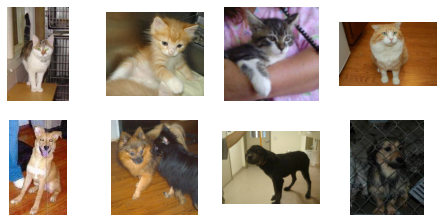

In [ ]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

# Display a batch of 4 cat and 4 dog pictures. You can rerun the cell to see a fresh batch each time:

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*2, nrows*2)

pic_index+=4

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-4:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-4:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

It may not be obvious from looking at the images in this grid, but an important note here, and a significant difference from the class session is that **these images come in all shapes and sizes.** When you did the horse vs human recognition , all images were of shapre 300x300 pixels. Cat and dog images are in color and in a variety of shapes. **Before training a Neural network with them we'll need to tweak the images.** You'll see how to do it later.

Ok, now that you have an idea for what your data looks like, the next step is to define the model that will be trained to recognize cats or dogs from these images 

## Building a Small Model 

In the previous section you saw that the images were in a variety of shapes and sizes. In order to train a neural network to handle them you'll need them to be in a uniform size. **We've chosen 150x150 for this**, and you'll see the code that preprocesses the images to that shape shortly. 

But before we continue, let's start defining the model:

Step 1 will be to import tensorflow.

In [ ]:
import tensorflow as tf
from tensorflow.python.keras import regularizers

Next You will define a Sequential layer as before, adding some convolutional layers first. Note the input shape parameter this time. In the earlier example it was 300x300x3, because the image was 300x300 in colorscale .**This time it is 150x150 for the size and 3 for the color depth.**


We then add a couple of convolutional layers as in the previous example, and flatten the final result to feed into the densely connected layers.

Finally we add the densely connected layers. 

Note that because we are facing a two-class classification problem, i.e. a *binary classification problem*, we will end our network with a [*sigmoid* activation](https://wikipedia.org/wiki/Sigmoid_function), so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

In [ ]:
model = tf.keras.models.Sequential([
    #CODE HERE!!!
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # Build 3 conv2d and pooling...
    #look at the model summary below!!!
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
        
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),

    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),

    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')

])

The model.summary() method call prints a summary of the NN 

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)            

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)            

The "output shape" column shows how the size of your feature map evolves in 

*   List item
*   List item

each successive layer. The convolution layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the dimensions.

Next, we'll configure the specifications for model training. We will train our model with the `binary_crossentropy` loss, because it's a binary classification problem and our final activation is a sigmoid.  We will use the `rmsprop` optimizer with a learning rate of `0.001`. During training, we will want to monitor classification accuracy.

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of 20 images of size 150x150 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs: `fit`, `evaluate_generator`, and `predict_generator`.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150)) # this is the part, images are scaled to 150x150    
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150)) # this is the part, images are scaled to 150x150   


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Training
Let's train on all 2,000 images available, for 10 epochs, and validate on all 1,000 test images. (This may take a few minutes to run.)

The Loss and Accuracy are a great indication of progress of training. It's making a guess as to the classification of the training data, and then measuring it against the known label, calculating the result. Accuracy is the portion of correct guesses. The Validation accuracy is the measurement with the data that has not been used in training. As expected this would be a bit lower. You'll learn about why this occurs in the section on overfitting later in this course.


In [ ]:
#This may take up to 20 minutes to run. This is normal given data size, number of convolutions and number of epochs. 
history = model.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=100,
                              epochs=15,
                              validation_steps=50,
                              verbose=2)

Epoch 1/15
100/100 - 7s - loss: 0.6785 - accuracy: 0.5740 - val_loss: 0.7013 - val_accuracy: 0.5330
Epoch 2/15
100/100 - 7s - loss: 0.5950 - accuracy: 0.6960 - val_loss: 0.5850 - val_accuracy: 0.6840
Epoch 3/15
100/100 - 8s - loss: 0.5334 - accuracy: 0.7280 - val_loss: 0.5711 - val_accuracy: 0.6970
Epoch 4/15
100/100 - 8s - loss: 0.4449 - accuracy: 0.7945 - val_loss: 0.6229 - val_accuracy: 0.7020
Epoch 5/15
100/100 - 8s - loss: 0.3697 - accuracy: 0.8355 - val_loss: 0.6775 - val_accuracy: 0.7000
Epoch 6/15
100/100 - 7s - loss: 0.2879 - accuracy: 0.8785 - val_loss: 0.7382 - val_accuracy: 0.7180
Epoch 7/15
100/100 - 8s - loss: 0.2196 - accuracy: 0.9105 - val_loss: 0.7691 - val_accuracy: 0.7000
Epoch 8/15
100/100 - 8s - loss: 0.1525 - accuracy: 0.9400 - val_loss: 1.0057 - val_accuracy: 0.6900
Epoch 9/15
100/100 - 8s - loss: 0.1061 - accuracy: 0.9630 - val_loss: 0.9852 - val_accuracy: 0.7150
Epoch 10/15
100/100 - 8s - loss: 0.0831 - accuracy: 0.9740 - val_loss: 1.2479 - val_accuracy: 0.6980

### Evaluating Accuracy and Loss for the Model

Let's plot the training/validation accuracy and loss as collected during training:

Text(0.5, 1.0, 'Training and validation loss')

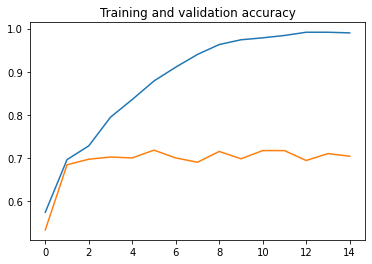

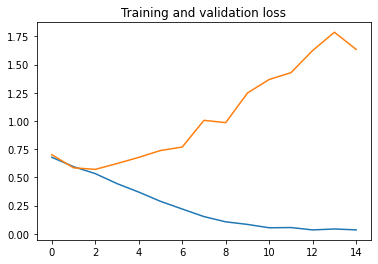

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

As you can see, we are **overfitting** like it's getting out of fashion. Our training accuracy (in blue) gets close to 100% (!) while our validation accuracy (in green) stalls as 70%. Our validation loss reaches its minimum after only five epochs.

Since we have a relatively small number of training examples (2000), overfitting should be our number one concern. Overfitting happens when a model exposed to too few examples learns patterns that do not generalize to new data, i.e. when the model starts using irrelevant features for making predictions. For instance, if you, as a human, only see three images of people who are lumberjacks, and three images of people who are sailors, and among them the only person wearing a cap is a lumberjack, you might start thinking that wearing a cap is a sign of being a lumberjack as opposed to a sailor. You would then make a pretty lousy lumberjack/sailor classifier.

Overfitting is the central problem in machine learning

Read the article at https://www.analyticsvidhya.com/blog/2020/09/overfitting-in-cnn-show-to-treat-overfitting-in-convolutional-neural-networks/

**Build another model and solve the overfitting issue. **

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Create the Validation Dataset
Xtrain, Xval, ytrain, yval = train_test_split(train_images, train_labels_final, train_size=0.9, test_size=0.1, random_state=42)# Create the Test and Final Training Datasets
Xtrain, Xtest, ytrain, ytest = train_test_split(Xtrain, ytrain, train_size=0.78, random_state=42)

NameError: ignored

In [ ]:
datagen = ImageDataGenerator(rotation_range = 0,
                             width_shift_range = 0,
                             height_shift_range = 0,
                             rescale = None,
                             shear_range = 0,
                             zoom_range = 0,
                             horizontal_flip = False,
                             fill_mode = 'nearest')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rotation_range = 0,
                             width_shift_range = 0,
                             height_shift_range = 0,
                             rescale = 1.0/255.,
                             shear_range = 0,
                             zoom_range = 0,
                             horizontal_flip = False,
                             fill_mode = 'nearest')
test_datagen  = ImageDataGenerator(rotation_range = 0,
                             width_shift_range = 0,
                             height_shift_range = 0,
                             rescale = 1.0/255.,
                             shear_range = 0,
                             zoom_range = 0,
                             horizontal_flip = False,
                             fill_mode = 'nearest')

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(300, 300)) # this is the part, images are scaled to 150x150    
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (300, 300)) # this is the part, images are scaled to 150x150   

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
import random

In [ ]:
random.seed(123)

In [ ]:
model = tf.keras.models.Sequential([
    #CODE HERE!!!
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # Build 3 conv2d and pooling...
    #look at the model summary below!!!
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=regularizers.l2(l=0.01), input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.4),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=regularizers.l2(l=0.01), input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal',input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),
 
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),

    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')

])

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#This may take up to 20 minutes to run. This is normal given data size, number of convolutions and number of epochs. 
history = model.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=100,
                              epochs=15,
                              validation_steps=50,
                              verbose=2)

Epoch 1/15
100/100 - 12s - loss: 3.9421 - accuracy: 0.5235 - val_loss: 0.8715 - val_accuracy: 0.5000
Epoch 2/15
100/100 - 11s - loss: 0.8240 - accuracy: 0.5370 - val_loss: 0.7599 - val_accuracy: 0.5090
Epoch 3/15
100/100 - 11s - loss: 0.7563 - accuracy: 0.5940 - val_loss: 0.7170 - val_accuracy: 0.6270
Epoch 4/15
100/100 - 11s - loss: 0.6852 - accuracy: 0.6460 - val_loss: 0.6949 - val_accuracy: 0.6500
Epoch 5/15
100/100 - 12s - loss: 0.6310 - accuracy: 0.6915 - val_loss: 0.6824 - val_accuracy: 0.6640
Epoch 6/15
100/100 - 12s - loss: 0.5787 - accuracy: 0.7285 - val_loss: 0.6383 - val_accuracy: 0.6950
Epoch 7/15
100/100 - 11s - loss: 0.5251 - accuracy: 0.7790 - val_loss: 0.6648 - val_accuracy: 0.6760
Epoch 8/15
100/100 - 11s - loss: 0.4797 - accuracy: 0.7855 - val_loss: 0.6421 - val_accuracy: 0.7020
Epoch 9/15
100/100 - 11s - loss: 0.4054 - accuracy: 0.8300 - val_loss: 0.6854 - val_accuracy: 0.6700
Epoch 10/15
100/100 - 11s - loss: 0.3581 - accuracy: 0.8550 - val_loss: 0.6895 - val_accura

Text(0.5, 1.0, 'Training and validation loss')

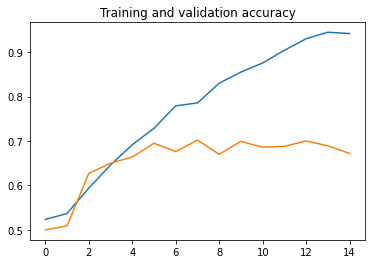

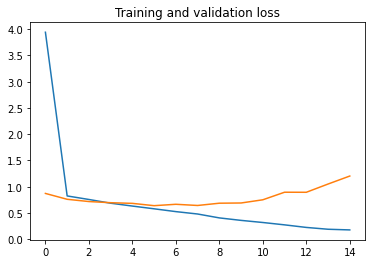

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

## Clean Up

Run the following cell to terminate the kernel and free memory resources:

In [ ]:
import os, signal

os.kill(     os.getpid() , 
         signal.SIGKILL
       )